IMPORTING NECESSARY LIBRARIES

In [1]:
import cv2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob
import scipy.io
import mediapipe as mp

In [3]:
import warnings
warnings.filterwarnings("ignore")

DATASET - ALFW2000

In [4]:
# Load images into images_path:-->list of images names will be the output
images_paths = glob.glob('AFLW2000-3D/AFLW2000/*.jpg')
print('Number of images in the AFLW dataset: ', len(images_paths))

Number of images in the AFLW dataset:  2000


Image shape:  (450, 450, 3)


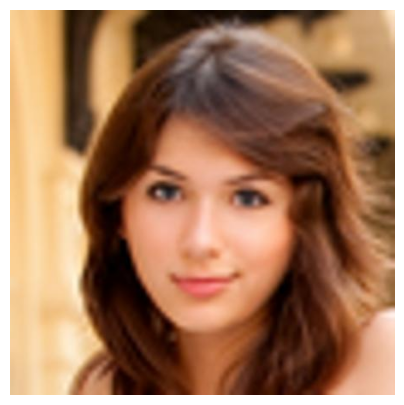

In [5]:
# Displaying the image
img_num = 500
image = cv2.imread(images_paths[img_num])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('Image shape: ', image.shape)
plt.figure(figsize=(5,5 ))
plt.axis('off')
plt.imshow(image)

In [10]:
# FOR EXTRACTING PITCH, YAW AND ROLL IN THE IMAGES 
# Step-1: --> Load all images into image information path
image_information_path = glob.glob('AFLW2000-3D/AFLW2000/*.mat')
# Step-2: --> Extract information about image(contains,pose para, head para)
m = scipy.io.loadmat(image_information_path[img_num])
# Step-3: --> From pose para extract only pitch, yaw and roll
m['Pose_Para'][0][:3]

array([-0.16171686,  0.08579214,  0.02720232], dtype=float32)

nose position:  (218.18887889385223, 286.34611666202545)


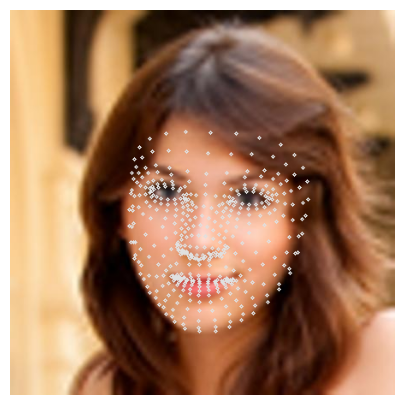

In [11]:
#Extracting Nose position from the image by using facial landmarks provided by MediaPipe
##
# Import the required modules from the MediaPipe library
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)
# Process the input image to detect facial landmarks
result = face_mesh.process(image)
# Get the dimensions of the input image
img_h, img_w, img_c = image.shape
# Create a copy of the input image for annotation
annot_img = image.copy()
# Check if there are multiple faces detected in the image
if result.multi_face_landmarks is not None:
    # Loop through each set of facial landmarks
    for face_landmarks in result.multi_face_landmarks:        
        # Draw the facial landmarks on the annotated image
        mp.solutions.drawing_utils.draw_landmarks(image=annot_img, landmark_list=face_landmarks, landmark_drawing_spec=drawing_specs)
        # Loop through each landmark point and find the nose position
        for idx, lm in enumerate(face_landmarks.landmark):
            # Check if the current landmark is the nose (index 1)
            if idx == 1:
                # Calculate the nose position in pixel coordinates
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h
# Print the nose position
print('nose position: ', (nose_x, nose_y))
# Display the annotated image using Matplotlib
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(annot_img)

In [12]:
# FOR DRAWING LINES ON 2D IMAGE
def draw_axes(image,pitch, yaw, roll, tx, ty, size=50):
    # Negate yaw to match the second approach in your description
    yaw = -yaw
    # Create a rotation matrix using Rodrigues formula
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    # Define the original axes in 3D space
    axes_points = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0]], dtype=np.float64)
    # Apply Euler rotation to the axes
    axes_points = rotation_matrix @ axes_points
    # Project the rotated axes onto the 2D image plane
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    # Create a copy of the input image for visualization
    new_image = image.copy()
    # Draw lines and labels for the x, y, and z axes
    cv2.line(new_image, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)
    cv2.putText(new_image, 'x', tuple(axes_points[:, 0].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1)
    #Y AXIS
    cv2.line(new_image, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.putText(new_image, 'y', tuple(axes_points[:, 1].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 0), 1)
    # Z- AXIS
    cv2.line(new_image, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    cv2.putText(new_image, 'z', tuple(axes_points[:, 2].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1)
    return new_image


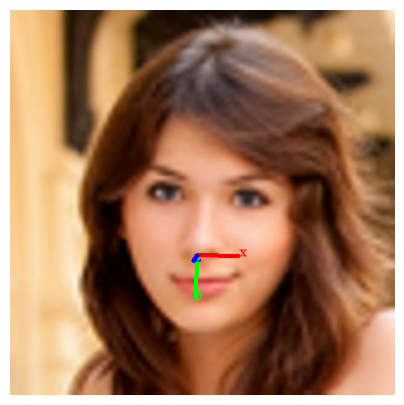

In [13]:
# DRAW LINES ON IMAGE
pitch, yaw, roll = m['Pose_Para'][0][:3]
new_img = draw_axes(image, pitch, yaw, roll, nose_x, nose_y)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(new_img)

In [14]:
# We have many uncessary landmarks, from that we are extracting key landmarks only
def extract_features(image, face_mesh, matrix=None):
    LANDMARKS = [1, 10, 33, 61, 199,263 , 291]  #  Nose,Forehead,Left Eye, Mouth Left,Chin,Right Eye, Mouth Right

    result = face_mesh.process(image)
    facial_features = []

    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            for idx, landmark in enumerate(face_landmarks.landmark):
                if idx in LANDMARKS:
                    facial_features.extend([landmark.x, landmark.y])
    else:
        facial_features.extend([None] * len(LANDMARKS) * 2)
    if matrix:
        pose_angles = matrix.get('Pose_Para', [[0, 0, 0]])[0][:3]
        facial_features.extend(pose_angles)

    return facial_features


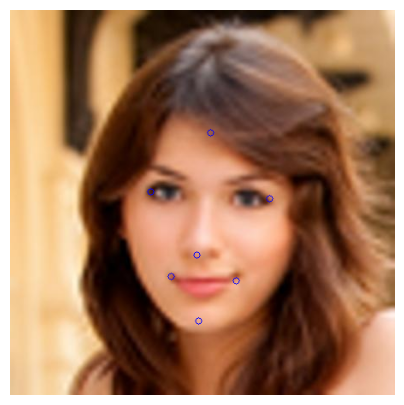

In [15]:
#Plotting them on facial image
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
key_features = extract_features(image, face_mesh)
annot_img = image.copy()
for i in range(len(key_features)//2):
        cv2.circle(annot_img, center=[int(key_features[i*2]*img_w), int(key_features[i*2+1]*img_h)], radius=4, color=(0, 0, 255))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(annot_img)

SAVING KEY LANDMARKS AND (PITCH,YAW,ROLL) IN CSV FILE

In [16]:
positional_info = ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']
dimensions = ('x', 'y')
cols = [pos + dim for pos in positional_info for dim in dimensions]
cols.extend(['pitch', 'yaw', 'roll'])


In [17]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
final_df = []
for image_index, image_path in enumerate(images_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    m = scipy.io.loadmat(image_information_path[image_index])
    facial_features = extract_features(image, face_mesh,m)
    final_df.append(facial_features)
final_df = pd.DataFrame(final_df, columns=cols)


In [18]:
final_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


REMOVING NULL VALUES

In [19]:
final_df = final_df.dropna(axis=0)
final_df.shape

(1792, 17)

In [20]:
def normalize_dataframe(final_df):
    # Create a copy of the original DataFrame to store normalized values
    normalized_df = final_df.copy()
    
    # Iterate over each dimension ('x' and 'y') for normalization
    for dimension in ['x', 'y']:
        # Centering around the nose
        centering_features = ['forehead_'+dimension, 'nose_'+dimension, 'mouth_left_'+dimension, 'mouth_right_'+dimension, 'left_eye_'+dimension, 'chin_'+dimension, 'right_eye_'+dimension]
        normalized_df[centering_features] = normalized_df[centering_features].sub(final_df['nose_'+dimension], axis=0)
        
        # Scaling based on the distance between 'mouth_right' and 'left_eye'
        difference_scaling = normalized_df['mouth_right_'+dimension] - normalized_df['left_eye_'+dimension]
        scaling_features = ['forehead_'+dimension, 'nose_'+dimension, 'mouth_left_'+dimension, 'mouth_right_'+dimension, 'left_eye_'+dimension, 'chin_'+dimension, 'right_eye_'+dimension]
        normalized_df[scaling_features] = normalized_df[scaling_features].div(difference_scaling, axis=0)
    
    return normalized_df


In [21]:
final_df = normalize_dataframe(final_df)
final_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.0,0.0,-0.069582,-1.516075,-0.835918,-0.675221,-0.497313,0.355848,-0.156862,0.798616,0.459186,-0.690928,0.164082,0.324779,-0.306358,-0.283822,0.038554
1992,0.0,0.0,-0.034515,-1.424327,-0.886287,-0.717177,-0.613809,0.292342,-0.229223,0.765727,0.467706,-0.711614,0.113713,0.282823,-0.367547,-0.429723,0.122791
1994,0.0,0.0,0.424978,-1.002710,-0.711851,-0.594513,-0.683567,0.258108,-0.404571,0.692207,0.930189,-0.319230,0.288149,0.405487,-0.156035,0.567114,-0.108536
1995,0.0,0.0,0.170664,-1.239908,-0.620394,-0.700198,-0.348568,0.218915,-0.016775,0.625044,0.910883,-0.509458,0.379606,0.299802,-0.197102,-0.070430,0.105118


PREDICTION USING ABOVE DF

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout

In [18]:
from math import sqrt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [20]:
X_train = train_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_train = train_df[['pitch', 'yaw', 'roll']]
X_val = val_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y_val = val_df[['pitch', 'yaw', 'roll']]

In [21]:
print(X_train.shape,X_val.shape)

(1433, 14) (359, 14)


In [22]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
model = Sequential()
model.add(Dense(256, input_dim=14, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(3))  

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3840      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [25]:
headpose_model = model

In [26]:
hist = headpose_model.fit(X_train_scaled, y_train, epochs=70, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/70
45/45 [==============================] - 2s 11ms/step - loss: 0.1850 - val_loss: 0.1079
Epoch 2/70
45/45 [==============================] - 0s 4ms/step - loss: 0.2809 - val_loss: 0.1601
Epoch 3/70
45/45 [==============================] - 0s 4ms/step - loss: 0.1231 - val_loss: 0.1363
Epoch 4/70
45/45 [==============================] - 0s 7ms/step - loss: 0.1695 - val_loss: 0.1384
Epoch 5/70
45/45 [==============================] - 0s 6ms/step - loss: 0.0865 - val_loss: 0.1408
Epoch 6/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0939 - val_loss: 0.1260
Epoch 7/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0860 - val_loss: 0.1278
Epoch 8/70
45/45 [==============================] - 0s 5ms/step - loss: 0.0768 - val_loss: 0.1357
Epoch 9/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0828 - val_loss: 0.1212
Epoch 10/70
45/45 [==============================] - 0s 4ms/step - loss: 0.0705 - val_loss: 0.1140
Epoch 11/70
45/45 

In [27]:
model.save('headpose_model.h5')

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
ann_predictions = headpose_model.predict(X_val_scaled)
ann_mse = mean_squared_error(y_val, ann_predictions)

12/12 [==============================] - 0s 2ms/step


In [29]:
ann_rmse = sqrt(ann_mse)  # Calculate RMSE
print("ANN Root Mean Squared Error:", ann_rmse)
print("ANN mean square error is: ",ann_mse)

ANN Root Mean Squared Error: 0.19733807219341237
ANN mean square error is:  0.03894231473701243


In [23]:
model = pickle.load(open(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\CODES\model.pkl", 'rb'))

In [24]:
headpose_model = model

TESTING

IMAGES

In [25]:
def label_pred(pitch_pred,yaw_pred):
    if pitch_pred > 0.3:
        text = 'Top'
        if yaw_pred > 0.3:
            text = 'Top Left'
        elif yaw_pred < -0.3:
            text = 'Top Right'
    elif pitch_pred < -0.3:
        text = 'Bottom'
        if yaw_pred > 0.3:
            text = 'Bottom Left'
        elif yaw_pred < -0.3:
            text = 'Bottom Right'
    elif yaw_pred > 0.3:
        text = 'Left'
    elif yaw_pred < -0.3:
        text = 'Right'
    else:
        text = 'Forward'
    return text

In [32]:
def plot_and_output_direction(image):
    face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    face_features = extract_features(image, face_mesh)
    face_features_df1 = pd.DataFrame([face_features],columns=cols[:14])
    face_features_normalized = normalize_dataframe(face_features_df1)
    pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
    # print('predictions: ', pitch_pred, yaw_pred, roll_pred)
    image_h, image_w, image_c = image.shape
    nose_x = face_features_df1['nose_x'].values * image_w
    nose_y = face_features_df1['nose_y'].values * image_h
    new_image = draw_axes(image, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(new_image)
    label = label_pred(pitch_pred,yaw_pred)
    print('Student is looking',label)

TEST_IMAGE_1

Student is looking Forward


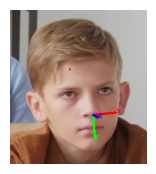

In [33]:
img = cv2.imread(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\headpose\img1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print('Image shape: ', img.shape)
plot_and_output_direction(img)

TEST IMAGE -2

Student is looking Right


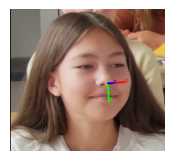

In [34]:
img2 = cv2.imread(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\headpose\img5.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# print('Image shape: ', img2.shape)
plot_and_output_direction(img2)

TEST IMAGE -3

Image shape:  (247, 214, 3)
predictions:  0.023982913716493262 -0.022880880010939714 -0.08775315870361808
Student is looking Forward


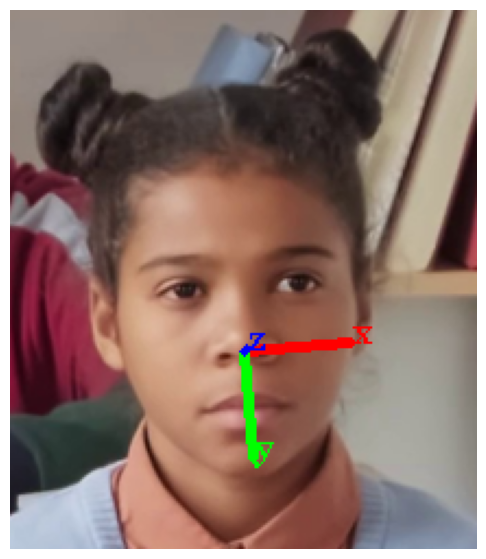

In [55]:
img3 = cv2.imread(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\headpose\img2.png")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
print('Image shape: ', img3.shape)
plot_and_output_direction(img3)

TEST IMAGE 4

Image shape:  (127, 164, 3)
predictions:  -0.2426006237138406 0.9508519193870115 -0.35166644694644983
Student is looking Left


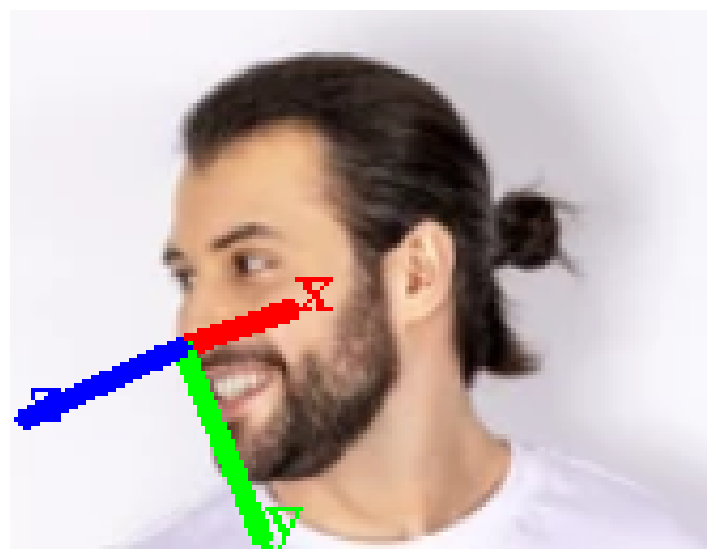

In [64]:
img3 = cv2.imread(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\headpose\img7.png")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
print('Image shape: ', img3.shape)
plot_and_output_direction(img3)

TEST IMAGE 5

Student is looking Forward


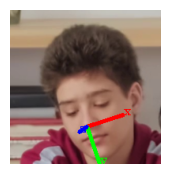

In [36]:
img3 = cv2.imread(r"C:\Users\DELL\Desktop\FINAL YEAR PROJECT\headpose\img3.png")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
# print('Image shape: ', img3.shape)
plot_and_output_direction(img3)

WEBCAM

In [47]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)  # From Camera

while(cap.isOpened()):

    # Take each frame
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        img_h, img_w, img_c = img.shape
        text = ''
        
        
        face_features = extract_features(img, face_mesh)
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols[:14])
            face_features_normalized = normalize_dataframe(face_features_df)
            pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('img', img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

cv2.destroyAllWindows()
cap.release()